# Chromo - Software for Radiochromic Film Processing

In [1]:
#PARAMETRI MODIFICABILI

maxdoseRecalibration = 6 #DOSE MASSIMA DI RICALIBRAZIONE
dpi = 150
path='scansPoli/' #PATH DELLE CARTELLE CALIBRATION TREATMENT E OUTPUT

isodoseDifferenceGy = 0.1 #DIFFERENZA ISODOSI DI VISUALIZZAZIONE (GY)

redChannel=2 #ORDINE RGB
greenChannel=1 #ORDINE RGB
blueChannel=0 #ORDINE RGB

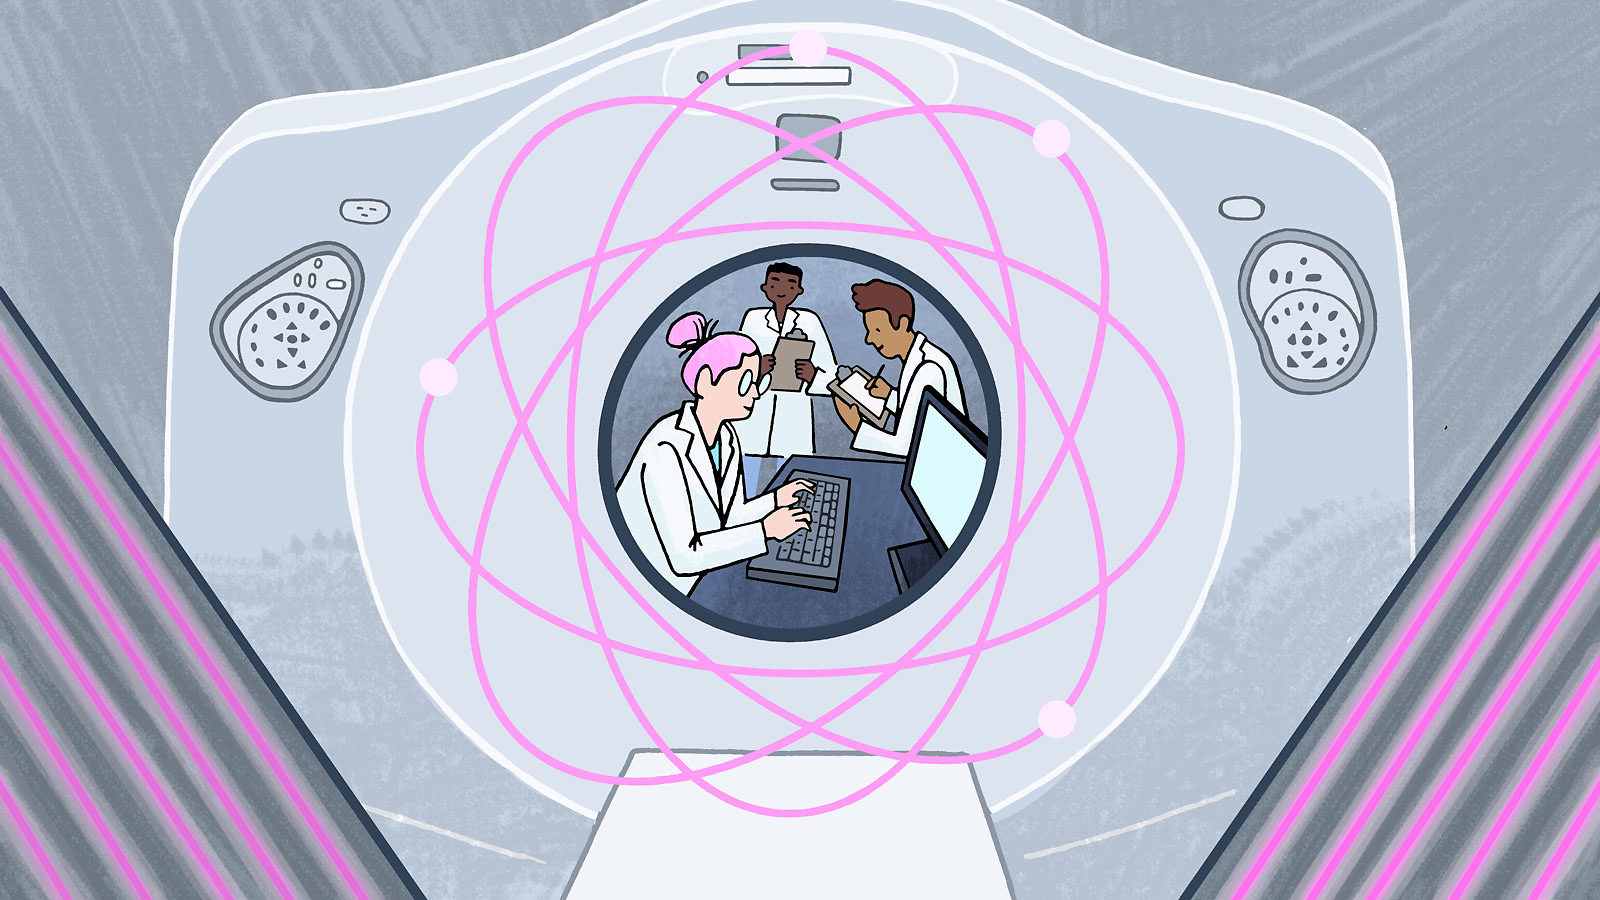

In [2]:
#TODO:
#fit razionale OK
#LS 3 colori OK
#ricalibrazione con d0 e dmax ok
#filtro mediano OK
#filtro wiener OK
#funzione inversa per dose-risposte risposta-dose OK 
#inverso della ricalibrazione dose-risposte risposta-dose OK
#media delle immagini di calibrazione solo al centro OK
#plottare i profili OK
#normalizzazione
#fittare profili e FWHM

import numpy as np
from glob import glob
import re
import numpy as np
import math
from scipy import ndimage
from matplotlib import gridspec
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt, wiener
from pynverse import inversefunc
import cv2
import PIL
import time
from IPython.display import Image
import os
import glob as gb
%matplotlib inline
Image(filename='mpj.jpg')

In [3]:
def a_recalibration(yp1, yp2, y1, y2):
    return (y2*yp1-y1*yp2)/(y2-y1)

def b_recalibration(yp1, yp2, y1, y2):
    return (yp2-yp1)/(y2-y1)

def rational(x, a, b, c):
    return a + b/(x+c)

def rational_inverse(x, a, b, c):
    return (b +a*c - x*c)/(x-a)

def multichannel_model(a, x):
    return a[0] + a[1]/(x+a[2])

def multichannel_function(a, x, y):
    return multichannel_model(a, x) - y

def jac(a, x, y):
    J = np.empty((x.size, a.size))
    J[:, 0] = 1
    J[:, 1] = 1/(x + a[2])
    J[:, 2] = (-a[1])/(x+a[2])**2
    return J

def multichannel_function_inverse(a, x, y):
    return multichannel_model_inverse(a, x) - y 
    
def multichannel_model_inverse(a, x):
    return (a[1] + a[0]*a[2] - a[2]*x)/(x - a[0])

def jac_inverse(a, x, y):
    J = np.empty((x.size, a.size))
    J[:, 0] = (-a[1])/(x-a[0])**2
    J[:, 1] = 1/(x - a[0])
    J[:, 2] = -1
    return J

def averageImages(images):
    sumIm = 0
    for im in images:
        sumIm += im
    return im/len(images)

def create_inverse_spline(spline):    
    def inverse_spline(x_array):
        if type(x_array) is np.float64:
            x_array
            return return_inverse(x_array, spline)
        else:
            shape = np.shape(x_array)
            dim = len(shape)
            y = np.zeros(shape)
            
            if dim == 1:
                for i, x in enumerate(x_array):
                    y[i] = return_inverse(x, spline)
                    
            else:                
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        x = x_array[i, j]
                        y[i, j] = return_inverse(x, spline)
            return y 
    return inverse_spline

def return_inverse(x, spline):
    def to_minimise(y):
        return (spline(y) - x)**2
    result = minimize(to_minimise, [6])
    return result.x

def projection(image):
    proiezionex = []
    proiezioney = []
    sizex, sizey = image.shape
    for i in range(0,sizey):
        cumsumy = 0
        for j in range(0, sizex):
            cumsumy += image[i][j]
        proiezioney.append(cumsumy)
    proiezioney_arr = np.asanyarray(proiezioney)
    
    for i in range(0,sizex):
        cumsumx = 0
        for j in range(0, sizey):
            cumsumx += image[j][i]
        proiezionex.append(cumsumx)
    proiezionex_arr = np.asanyarray(proiezionex)
    return(proiezionex_arr, proiezioney_arr)

def calibration_factors_calculator(zeroResponse, maxdoseResponse):
        a = a_recalibration(zeroResponse, #x1
                            maxdoseResponse, #x2
                            multichannel_model(fitResults.x, 0), #n1
                            multichannel_model(fitResults.x, maxdoseRecalibration)) #n2
        b = b_recalibration(zeroResponse,
                            maxdoseResponse,
                            multichannel_model(fitResults.x, 0), #n1
                            multichannel_model(fitResults.x, maxdoseRecalibration)) #n2 
        return (a, b)

        
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text 
    
def plotTiff(listTiffs, prefix):
    rows = 3
    for num, x in enumerate(listTiffs):
        img = PIL.Image.open(x)
        plt.subplot(rows,2,num+1)
        plt.title(remove_prefix(x, prefix).split('.')[0])
        plt.axis('off')
        plt.imshow(img)
        
def startString():
    print("STARTING DOSE CALCULATION.")
    time.sleep(1)
    print("STARTING DOSE CALCULATION..")
    time.sleep(1)
    print("STARTING DOSE CALCULATION...")
    time.sleep(1)
    print("STARTING DOSE CALCULATION....")
    time.sleep(1)
    print("thank you for using Chromo :)")
    time.sleep(2.5)
    print()

calibration film list:
['scansPoli/CALIBRATION/calibration_10Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_15Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_2Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_5Gy_1.tif'
 'scansPoli/CALIBRATION/calibration_7Gy_1.tif']


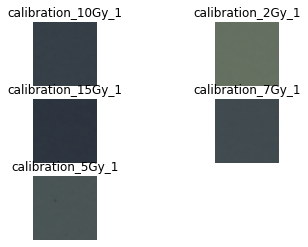

unexposed calibration film list:
['scansPoli/CALIBRATION/unexposed_calibration_0Gy_1.tif']


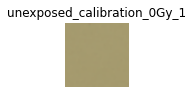

treatment film:
['scansPoli/TREATMENT/treatment_coll16xy.tif'
 'scansPoli/TREATMENT/treatment_coll16xz.tif'
 'scansPoli/TREATMENT/treatment_coll8xy.tif'
 'scansPoli/TREATMENT/treatment_coll8xz.tif']


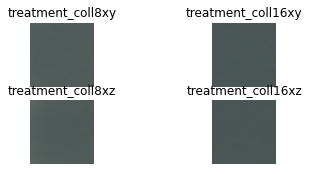

unexposed recalibration film:
['scansPoli/TREATMENT/unexposed_treatment_0Gy_coll16xy.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_coll16xz.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_coll8xy.tif'
 'scansPoli/TREATMENT/unexposed_treatment_0Gy_coll8xz.tif']


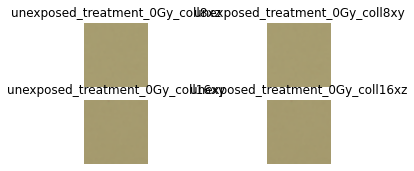

maxdose recalibration film:
['scansPoli/TREATMENT/maxdose_treatment_coll16xy.tif'
 'scansPoli/TREATMENT/maxdose_treatment_coll16xz.tif'
 'scansPoli/TREATMENT/maxdose_treatment_coll8xy.tif'
 'scansPoli/TREATMENT/maxdose_treatment_coll8xz.tif']


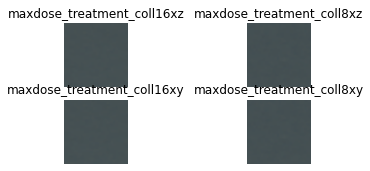

In [4]:
print("calibration film list:")
calibration_list = glob(path+"CALIBRATION/calibration*")  
print(np.sort(calibration_list))
plotTiff(calibration_list, path+ "CALIBRATION/")
plt.show()

unexposed_calibration_list = glob(path+"CALIBRATION/unexposed_calibration*")
print("unexposed calibration film list:")
print(np.sort(unexposed_calibration_list))
plotTiff(unexposed_calibration_list, path+ "CALIBRATION/")
plt.show()

treatment_list = glob(path+"TREATMENT/treatment*")
print("treatment film:")
print(np.sort(treatment_list))
plotTiff(treatment_list, path + "TREATMENT/")
plt.show()

unexposed_treatment_list = glob(path+"TREATMENT/unexposed_treatment*")
print("unexposed recalibration film:")
print(np.sort(unexposed_treatment_list))
plotTiff(unexposed_treatment_list, path + "TREATMENT/")
plt.show()

maxdose_treatment_list = glob(path+"TREATMENT/maxdose_treatment*")
print("maxdose recalibration film:")
print(np.sort(maxdose_treatment_list))
plotTiff(maxdose_treatment_list, path + "TREATMENT/")
plt.show()

In [5]:
calibration_dose = []
calibration_red = []
calibration_green = []
calibration_blue = []
unexposedImages = []
unexposedImagesRed = []
unexposedImagesGreen = []
unexposedImagesBlue = []
unexposedTreatementImages = []
unexposedTreatementsImagesRed = []
unexposedTreatementsImagesGreen = []
unexposedTreatementsImagesBlue = []
maxdoseTreatementImages = []
maxdoseTreatementsImagesRed = []
maxdoseTreatementsImagesGreen = []
maxdoseTreatementsImagesBlue = []
rescaled_unexposed_red = []
rescaled_maxdose_red = []

import tifffile as tiff
    
for i, scan_filepath in enumerate(unexposed_calibration_list):
    reg0_search = re.search('.*unexposed_calibration*', scan_filepath)
    calibration_dose.append(0)

    image = cv2.imread(scan_filepath)
    unexposedImages.append(image)
    unexposedImagesRed.append(image[:,:,redChannel])
    unexposedImagesGreen.append(image[:,:,greenChannel])
    unexposedImagesBlue.append(image[:,:,blueChannel])
        
    calibration_red.append(np.mean(image[10:20,10:20,redChannel]))
    calibration_green.append(np.mean(image[10:20,10:20,greenChannel]))
    calibration_blue.append(np.mean(image[10:20,10:20,blueChannel]))
    #prendo la media di ogni canale per la calibrazione di ogni immagine

unexposedCal = averageImages(unexposedImages)

for i, scan_filepath in enumerate(calibration_list):
    reg_search = re.search('.*calibration_(.*)Gy_.*', scan_filepath)
    calibration_dose.append(reg_search.group(1))
    
    image = cv2.imread(scan_filepath)
    netImage = image #/unexposedCal
    calibration_red.append(np.mean(netImage[10:20,10:20,redChannel]))
    calibration_green.append(np.mean(netImage[10:20,10:20,greenChannel]))
    calibration_blue.append(np.mean(netImage[10:20,10:20,blueChannel]))
    #prendo la media di ogni canale per la calibrazione di ogni immagine
    
for i, scan_filepath in enumerate(unexposed_treatment_list):
    reg_search = re.search('.*unexposed_treatment*', scan_filepath)
    
    image = cv2.imread(scan_filepath)
    unexposedTreatementImages.append(image)
    unexposedTreatementsImagesRed.append(image[:,:,redChannel])
    unexposedTreatementsImagesGreen.append(image[:,:,greenChannel])
    unexposedTreatementsImagesBlue.append(image[:,:,blueChannel])

for i, scan_filepath in enumerate(maxdose_treatment_list):
    reg_search = re.search('.*maxdose_treatment*', scan_filepath)
    
    image = cv2.imread(scan_filepath)
    maxdoseTreatementImages.append(image)
    maxdoseTreatementsImagesRed.append(image[:,:,redChannel])
    maxdoseTreatementsImagesGreen.append(image[:,:,greenChannel])
    maxdoseTreatementsImagesBlue.append(image[:,:,blueChannel])

In [6]:
calibration_dose = np.array(calibration_dose).astype(float)
calibration_red = np.array(calibration_red).astype(float)
calibration_green = np.array(calibration_green).astype(float)
calibration_blue = np.array(calibration_blue).astype(float)

initial_sorting_reference = np.argsort(calibration_dose)
calibration_dose = calibration_dose[initial_sorting_reference]
calibration_red = calibration_red[initial_sorting_reference]
calibration_green = calibration_green[initial_sorting_reference]
calibration_blue = calibration_blue[initial_sorting_reference]

RED POINTS CURVE



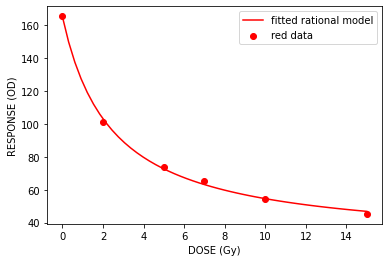

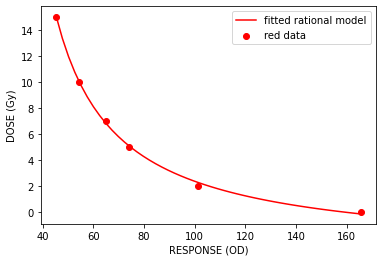

In [7]:
d = np.linspace(np.min(calibration_dose), np.max(calibration_dose))
p0 = -10., 200., 3.

print("RED POINTS CURVE")
print()

poptRed = curve_fit(rational, calibration_dose, calibration_red, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_red, color='red', label='red data')
plt.plot(d, rational(d, *poptRed), 'r-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_red), np.max(calibration_red))
p0 = -10., 300., 3.

poptRedInverse = curve_fit(rational_inverse, calibration_red, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_red, calibration_dose, color='red', label='red data')
plt.plot(r, rational_inverse(r, *poptRedInverse), 'r-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

GREEN POINTS CURVE



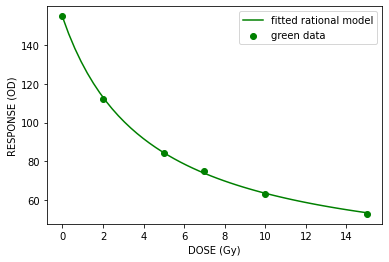

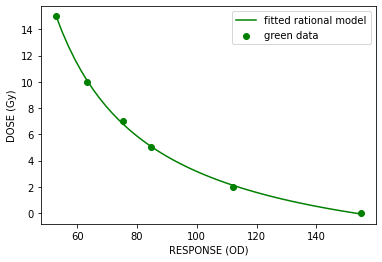

In [8]:
print("GREEN POINTS CURVE")
print()

poptGreen = curve_fit(rational, calibration_dose, calibration_green, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_green, color='green', label='green data')
plt.plot(d, rational(d, *poptGreen), 'g-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_green), np.max(calibration_green))

poptGreenInverse = curve_fit(rational_inverse, calibration_green, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_green, calibration_dose, color='green', label='green data')
plt.plot(r, rational_inverse(r, *poptGreenInverse), 'g-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

BLUE POINTS CURVE



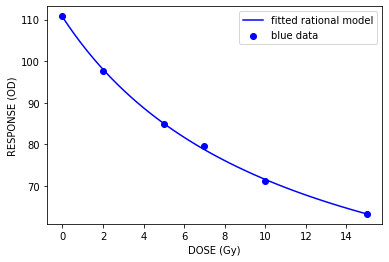

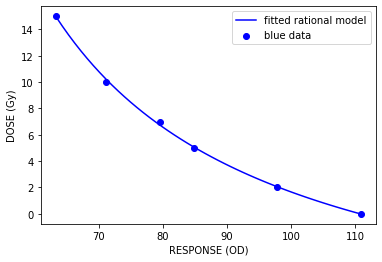

In [9]:
print("BLUE POINTS CURVE")
print()

poptBlue = curve_fit(rational, calibration_dose, calibration_blue, p0, maxfev=1000)[0]
plt.scatter(calibration_dose, calibration_blue, color='blue', label='blue data')
plt.plot(d, rational(d, *poptBlue), 'b-', label='fitted rational model')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

r = np.linspace(np.min(calibration_blue), np.max(calibration_blue))

poptBlueInverse = curve_fit(rational_inverse, calibration_blue, calibration_dose, p0, maxfev=1000)[0]
plt.scatter(calibration_blue, calibration_dose, color='blue', label='blue data')
plt.plot(r, rational_inverse(r, *poptBlueInverse), 'b-', label='fitted rational model')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

THREE CHANNEL CURVE

`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 5.5144e+01, final cost 3.6859e+01, first-order optimality 1.38e+00.


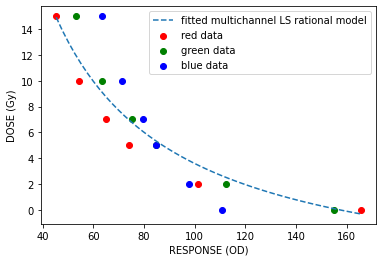

`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 4.2372e+04, final cost 1.1506e+03, first-order optimality 1.43e-04.


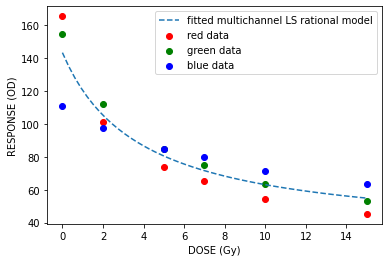

In [10]:
print("THREE CHANNEL CURVE")
print()

xi = np.append(np.asanyarray(calibration_red), np.asanyarray(calibration_green))
x = np.append(xi, np.asanyarray(calibration_blue))

yi = np.append(np.asanyarray(calibration_dose), np.asanyarray(calibration_dose))
y = np.append(yi, np.asanyarray(calibration_dose))

a0 = np.array([0, 1000, 5]) #cambiare il secondo parametro prima era 500
fitResults_inv = least_squares(multichannel_function_inverse, a0, jac=jac_inverse, method='lm', args=(x, y), max_nfev=1000000000, verbose=1)
fitResults_inv.x

x_calibration_fit = np.linspace(min(x), max(x))
y_calibration_fit = multichannel_model_inverse(fitResults_inv.x, x_calibration_fit)
plt.scatter(calibration_red, calibration_dose, color='red', label='red data')
plt.scatter(calibration_green, calibration_dose,color='green', label='green data')
plt.scatter(calibration_blue, calibration_dose, color='blue', label='blue data')
plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
plt.xlabel("RESPONSE (OD)")
plt.ylabel("DOSE (Gy)")
plt.legend(loc='upper right')
plt.show()

xi = np.append(np.asanyarray(calibration_dose), np.asanyarray(calibration_dose))
x = np.append( xi, np.asanyarray(calibration_dose))

yi = np.append(np.asanyarray(calibration_red), np.asanyarray(calibration_green))
y = np.append( yi, np.asanyarray(calibration_blue))

a0 = np.array([-10, 200, 3])
fitResults = least_squares(multichannel_function, a0, jac=jac, args=(x, y), verbose=1)
fitResults.x

x_calibration_fit = np.linspace(0, max(x))
y_calibration_fit = multichannel_model(fitResults.x, x_calibration_fit)
plt.scatter(calibration_dose, calibration_red, color='red', label='red data')
plt.scatter(calibration_dose, calibration_green, color='green', label='green data')
plt.scatter(calibration_dose, calibration_blue, color='blue', label='blue data')
plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
plt.xlabel("DOSE (Gy)")
plt.ylabel("RESPONSE (OD)")
plt.legend(loc='upper right')
plt.show()

TREATMENT NUMBER  1

 filepath = scansPoli/TREATMENT/treatment_coll8xy.tif

 RED: min, mean, max predicted dose = 4.3, 4.6, 4.7 Gy
 GREEN: min, mean, max predicted dose = 3.8, 4.2, 4.3 Gy
 BLUE: min, mean, max predicted dose = 2.9, 3.4, 3.7 Gy
 3 CHANNEL WEIGHTED: min, mean, max predicted dose = 3.7, 4.1, 4.2 Gy



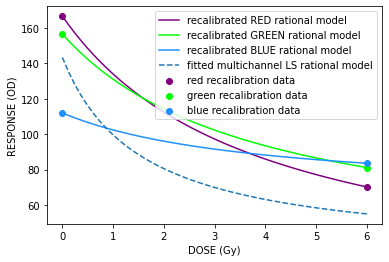

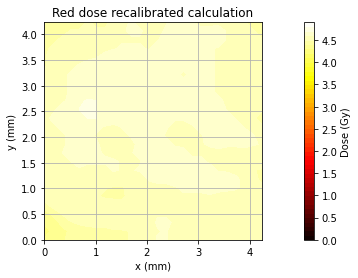

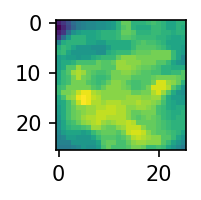

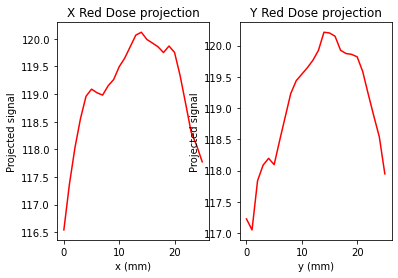

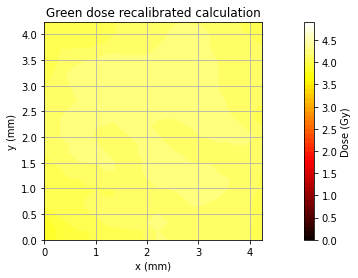

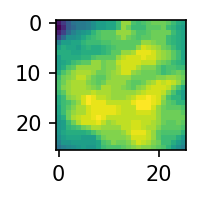

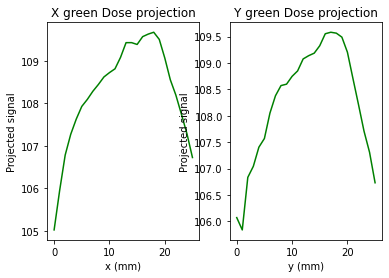

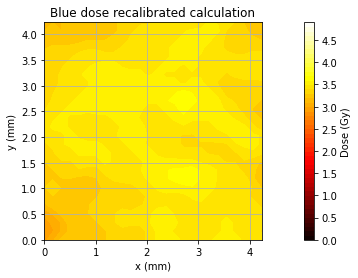

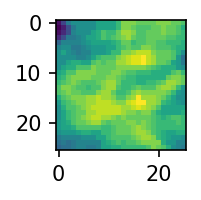

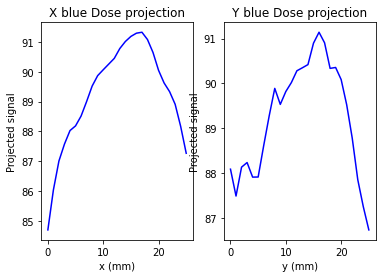

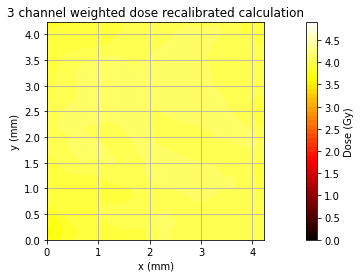

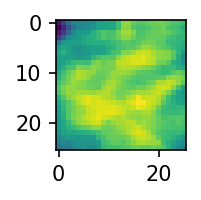

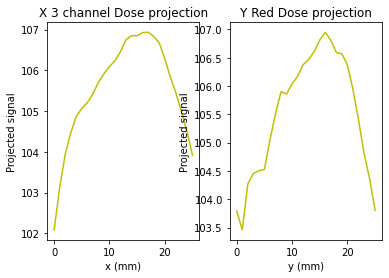

TREATMENT NUMBER  2

 filepath = scansPoli/TREATMENT/treatment_coll16xy.tif

 RED: min, mean, max predicted dose = 5.1, 5.2, 5.3 Gy
 GREEN: min, mean, max predicted dose = 4.7, 4.9, 5.0 Gy
 BLUE: min, mean, max predicted dose = 4.1, 4.4, 4.7 Gy
 3 CHANNEL WEIGHTED: min, mean, max predicted dose = 4.6, 4.8, 5.0 Gy



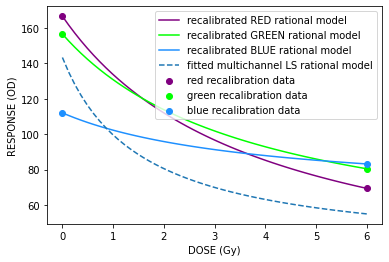

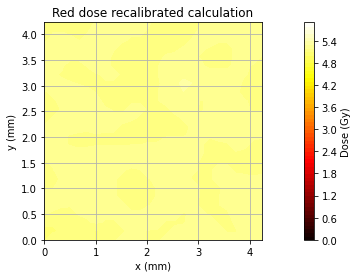

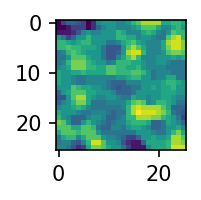

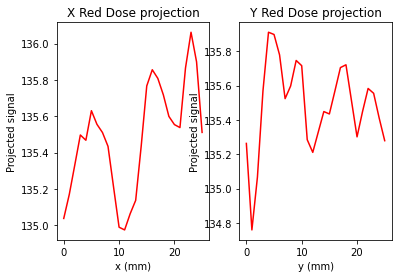

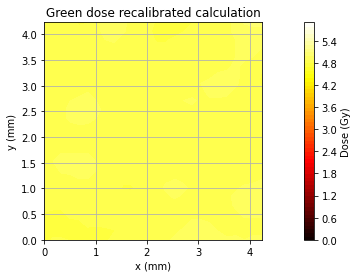

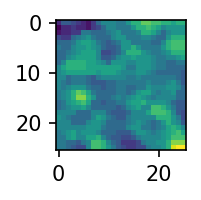

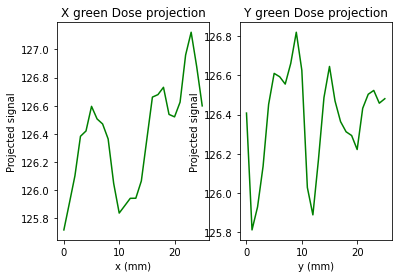

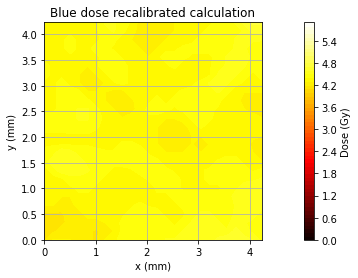

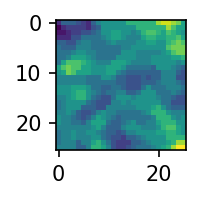

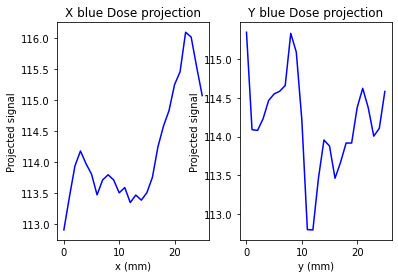

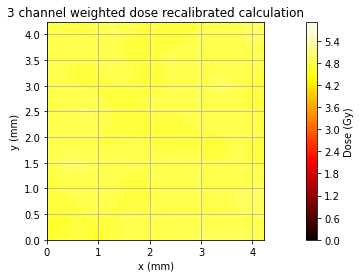

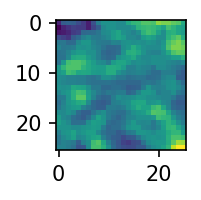

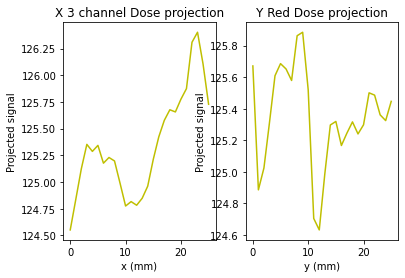

TREATMENT NUMBER  3

 filepath = scansPoli/TREATMENT/treatment_coll8xz.tif

 RED: min, mean, max predicted dose = 4.0, 4.7, 4.9 Gy
 GREEN: min, mean, max predicted dose = 3.4, 4.2, 4.4 Gy
 BLUE: min, mean, max predicted dose = 2.5, 3.6, 4.1 Gy
 3 CHANNEL WEIGHTED: min, mean, max predicted dose = 3.3, 4.1, 4.4 Gy



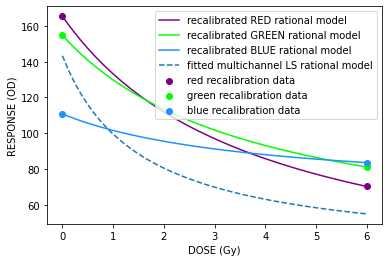

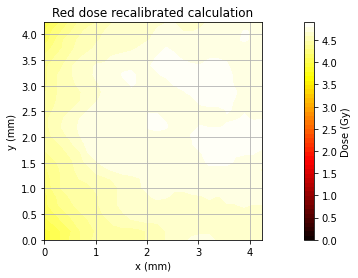

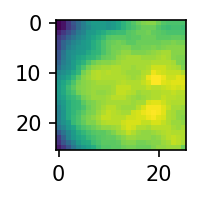

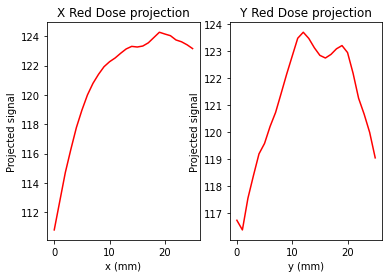

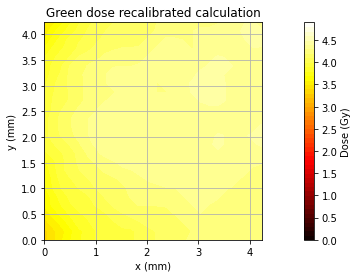

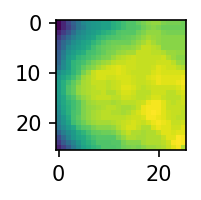

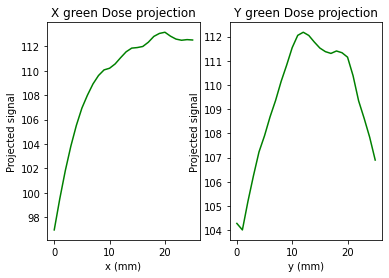

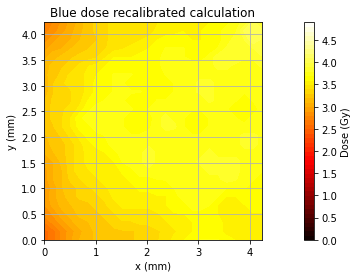

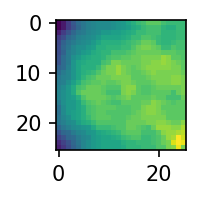

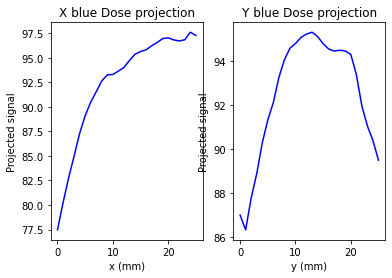

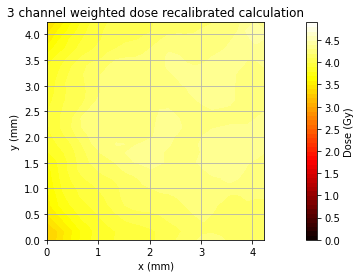

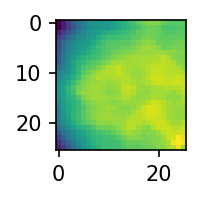

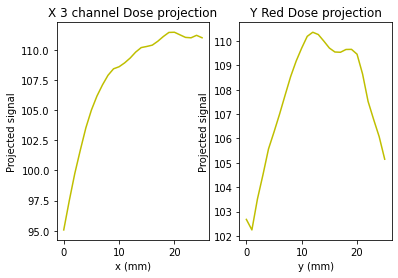

TREATMENT NUMBER  4

 filepath = scansPoli/TREATMENT/treatment_coll16xz.tif

 RED: min, mean, max predicted dose = 5.1, 5.3, 5.4 Gy
 GREEN: min, mean, max predicted dose = 4.9, 5.1, 5.2 Gy
 BLUE: min, mean, max predicted dose = 4.6, 4.9, 5.3 Gy
 3 CHANNEL WEIGHTED: min, mean, max predicted dose = 4.9, 5.1, 5.3 Gy



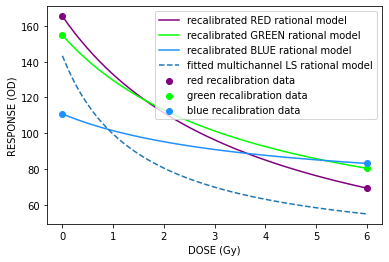

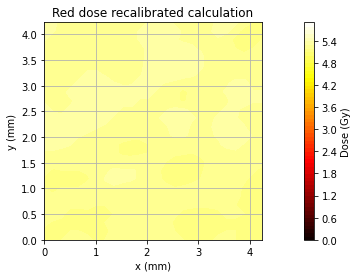

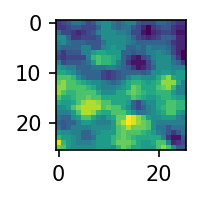

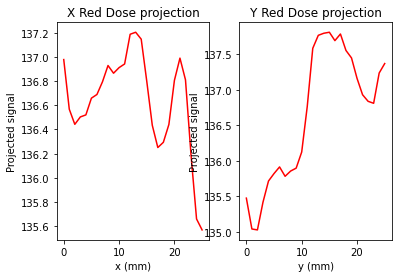

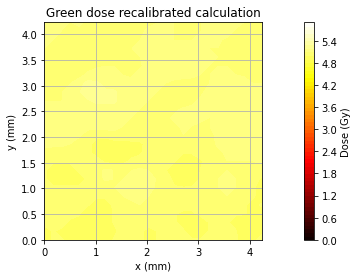

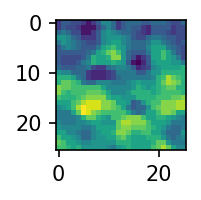

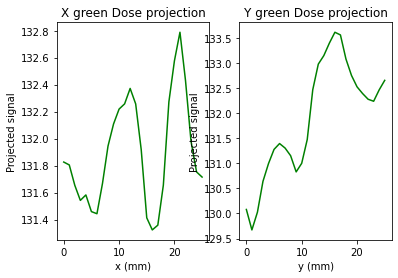

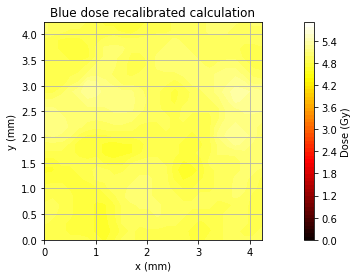

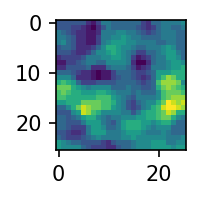

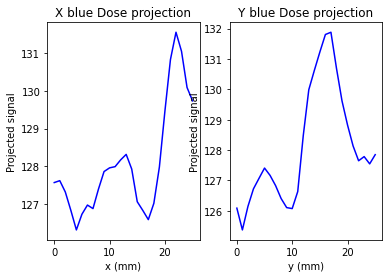

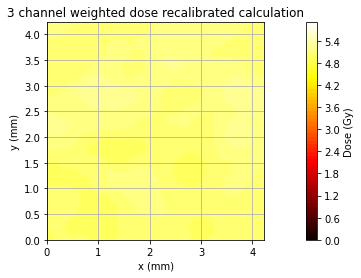

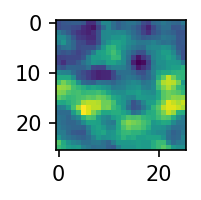

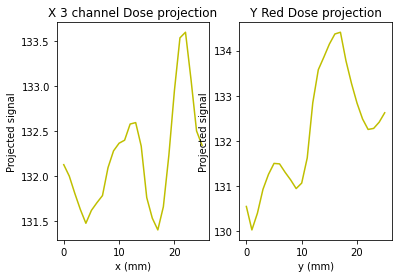

In [11]:
outputPath = path + 'OUTPUT'
dpiResolution = 25.4 / dpi

files = gb.glob(outputPath +'/RED/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/GREEN/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/BLUE/*')
for f in files:
    os.remove(f)
files = gb.glob(outputPath +'/3CH/*')
for f in files:
    os.remove(f)


for i, scan_filepath in enumerate(treatment_list):  
    #startString()

    unexposed_treatment_filepath = unexposed_treatment_list[i]
    maxdose_treatment_filepath = maxdose_treatment_list[i]
    image = cv2.imread(scan_filepath)
    netImage = image #unexposed_treatment_image
    
    unexposed_treatment_image = cv2.imread(unexposed_treatment_filepath)
    #zero_dose_red = multichannel_model_inverse(fitResults_inv.x, zero_response_red)
    zero_response_red = np.mean(unexposed_treatment_image[10:20,10:20,redChannel]) #response che corrisponde a dose 0
    zero_response_green = np.mean(unexposed_treatment_image[10:20,10:20,greenChannel])
    zero_response_blue = np.mean(unexposed_treatment_image[10:20,10:20,blueChannel])
    
    maxdose_treatment_image = cv2.imread(maxdose_treatment_filepath)
    #maxdose_dose_red = multichannel_model_inverse(fitResults_inv.x, maxdose_response_red)
    maxdose_response_red = np.mean(maxdose_treatment_image[10:20,10:20,redChannel])
    maxdose_response_green = np.mean(maxdose_treatment_image[10:20,10:20,greenChannel])
    maxdose_response_blue = np.mean(maxdose_treatment_image[10:20,10:20,blueChannel])
            
    a_red = calibration_factors_calculator(zero_response_red, maxdose_response_red)[0]  
    b_red = calibration_factors_calculator(zero_response_red, maxdose_response_red)[1]  
    a_green = calibration_factors_calculator(zero_response_green, maxdose_response_green)[0]  
    b_green = calibration_factors_calculator(zero_response_green, maxdose_response_green)[1]  
    a_blue = calibration_factors_calculator(zero_response_blue, maxdose_response_blue)[0]  
    b_blue = calibration_factors_calculator(zero_response_blue, maxdose_response_blue)[1]  
    
    def recalibrated_multichannel_response_curve_red(x):
        return a_red + b_red*multichannel_model(fitResults.x, x)
    def recalibrated_multichannel_response_curve_green(x):
        return a_green + b_green*multichannel_model(fitResults.x, x)    
    def recalibrated_multichannel_response_curve_blue(x):
        return a_blue + b_blue*multichannel_model(fitResults.x, x)
    
    inverse_recalibrated_multichannel_response_curve_red = inversefunc(recalibrated_multichannel_response_curve_red)
    inverse_recalibrated_multichannel_response_curve_green = inversefunc(recalibrated_multichannel_response_curve_green)
    inverse_recalibrated_multichannel_response_curve_blue = inversefunc(recalibrated_multichannel_response_curve_blue)

    print("TREATMENT NUMBER " , i+1)
    print()
    print(" filepath = %s" % (scan_filepath))
    print()
    #red
    filtered_red = medfilt(wiener(netImage[:,:,redChannel])[-1:1:-1,1:-1])[1:-1,1:-1]
    dose_red = inverse_recalibrated_multichannel_response_curve_red(filtered_red) #inverso del filtrato
    max_red = np.max(dose_red)
    avg_red = np.mean(dose_red)
    min_red = np.min(dose_red)
    print(" RED: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" % (min_red, avg_red, max_red))
    #green
    filtered_green = medfilt(wiener(netImage[:,:,greenChannel])[-1:1:-1,1:-1])[1:-1,1:-1]
    dose_green = inverse_recalibrated_multichannel_response_curve_green(filtered_green) 
    max_green = np.max(dose_green)
    avg_green = np.mean(dose_green)
    min_green = np.min(dose_green)
    print(" GREEN: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" % (min_green, avg_green, max_green ))
    #blue
    filtered_blue = medfilt(wiener(netImage[:,:,blueChannel])[-1:1:-1,1:-1])[1:-1,1:-1] 
    dose_blue = inverse_recalibrated_multichannel_response_curve_blue(filtered_blue)
    max_blue = np.max(dose_blue)
    avg_blue = np.mean(dose_blue)
    min_blue = np.min(dose_blue)        
    print(" BLUE: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" % (min_blue, avg_blue, max_blue ))
    #3 channel    
    dose_3ch = (dose_blue + dose_red + dose_green)/3
    max_3ch = np.max(dose_3ch)
    avg_3ch = np.mean(dose_3ch)
    min_3ch = np.min(dose_3ch)  
    print(" 3 CHANNEL WEIGHTED: min, mean, max predicted dose = %0.1f, %0.1f, %0.1f Gy" % (min_3ch, avg_3ch, max_3ch ))
    print()
    
    x_calibration_fit = np.linspace(0, maxdoseRecalibration)
    y_calibration_fit_red = recalibrated_multichannel_response_curve_red(x_calibration_fit)
    y_calibration_fit_green = recalibrated_multichannel_response_curve_green(x_calibration_fit)
    y_calibration_fit_blue = recalibrated_multichannel_response_curve_blue(x_calibration_fit)
    plt.scatter(0, zero_response_red, color='purple', label='red recalibration data')
    plt.scatter(0, zero_response_green, color='lime', label='green recalibration data')
    plt.scatter(0, zero_response_blue, color='dodgerblue', label='blue recalibration data')
    plt.scatter(maxdoseRecalibration, maxdose_response_red, color='purple')
    plt.scatter(maxdoseRecalibration, maxdose_response_green, color='lime')
    plt.scatter(maxdoseRecalibration, maxdose_response_blue, color='dodgerblue')
    plt.plot(x_calibration_fit, y_calibration_fit_red, 'purple', label='recalibrated RED rational model')
    plt.plot(x_calibration_fit, y_calibration_fit_green, 'lime', label='recalibrated GREEN rational model')
    plt.plot(x_calibration_fit, y_calibration_fit_blue, 'dodgerblue', label= 'recalibrated BLUE rational model')
    plt.plot(x_calibration_fit, y_calibration_fit, label='fitted multichannel LS rational model', ls='dashed')
    #plt.scatter(calibration_dose, calibration_red, color='red')
    #plt.scatter(calibration_dose, calibration_green, color='green')
    #plt.scatter(calibration_dose, calibration_blue, color='blue')
    plt.xlabel("DOSE (Gy)")
    plt.ylabel("RESPONSE (OD)")
    plt.legend(loc='upper right')
    plt.show()

    shape = np.shape(dose_red)
    x = np.arange(shape[1])*dpiResolution
    y = np.arange(shape[0])*dpiResolution
    xx, yy = np.meshgrid(x, y)
    levels = np.arange(0, int(math.ceil(max(max_red,max_green,max_blue)+isodoseDifferenceGy)), isodoseDifferenceGy)
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_red, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Red dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.show()
    
    height, width = np.array(dose_red.shape, dtype=float) / dpi
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0, 0, 5, 5])
    ax.axis('equal')
    ax.imshow(dose_red, interpolation='none')
    fig.savefig(outputPath + '/RED/dose_red'+str(i)+'.tif', dpi=dpi)
    
    red_x, red_y = projection(dose_red)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X Red Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(red_x,'r-')
    ax2.title.set_text('Y Red Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(red_y,'r-')
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_green, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Green dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    
    height, width = np.array(dose_green.shape, dtype=float) / dpi
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0, 0, 5, 5])
    ax.axis('equal')
    ax.imshow(dose_green, interpolation='none')
    fig.savefig(outputPath + '/GREEN/dose_green'+str(i)+'.tif', dpi=dpi)
    
    green_x, green_y = projection(dose_green)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X green Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(green_x,'g-')
    ax2.title.set_text('Y green Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(green_y,'g-')
    
    plt.figure()
    c = plt.contourf(xx, yy, dose_blue, cmap='hot', levels=levels)
    plt.colorbar(c, label="Dose (Gy)")
    plt.title("Blue dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    
    height, width = np.array(dose_blue.shape, dtype=float) / dpi
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0, 0, 5, 5])
    ax.axis('equal')
    ax.imshow(dose_blue, interpolation='none')
    fig.savefig(outputPath + '/BLUE/dose_blue'+str(i)+'.tif', dpi=dpi)
    
    blue_x, blue_y = projection(dose_blue)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X blue Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(blue_x,'b-')
    ax2.title.set_text('Y blue Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(blue_y,'b-')
    
    plt.figure()
    d = plt.contourf(xx, yy, (dose_red + dose_green + dose_blue)/3, cmap='hot', levels=levels)
    plt.colorbar(d, label="Dose (Gy)")
    plt.title("3 channel weighted dose recalibrated calculation")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("scaled")
    plt.grid(True)
    plt.show()
    
    height, width = np.array(((dose_red + dose_green + dose_blue)/3).shape, dtype=float) / dpi
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0, 0, 5, 5])
    ax.axis('equal')
    ax.imshow((dose_red + dose_green + dose_blue)/3, interpolation='none')
    fig.savefig(outputPath + '/3CH/dose_3ch'+str(i)+'.tif', dpi=dpi)
    
    tch_x, tch_y = projection((dose_red + dose_green + dose_blue)/3)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('X 3 channel Dose projection')
    ax1.set_ylabel('Projected signal')
    ax1.set_xlabel('x (mm)')
    ax1.plot(tch_x,'y-')
    ax2.title.set_text('Y Red Dose projection')
    ax2.set_ylabel('Projected signal')
    ax2.set_xlabel('y (mm)')
    ax2.plot(tch_y,'y-')
    
    plt.show()